In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 2

# Dataset reading

In [59]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [60]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 42)                0         
_________________________________________________________________
dense (Dense)                (None, 20)                860       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 22        
Total params: 1,092
Trainable params: 1,092
Non-trainable params: 0
_________________________________________________________________


In [9]:
import tensorflow_decision_forests as tfdf

model2 = tfdf.keras.RandomForestModel()

ModuleNotFoundError: No module named 'tensorflow_decision_forests'

In [10]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [11]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [62]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
39/39 [==============================] - 0s 4ms/step - loss: 0.2164 - accuracy: 0.9203 - val_loss: 0.1249 - val_accuracy: 0.9580

Epoch 00001: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 2/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.2122 - accuracy: 0.9169 - val_loss: 0.1259 - val_accuracy: 0.9586

Epoch 00002: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 3/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.2018 - accuracy: 0.9219 - val_loss: 0.1279 - val_accuracy: 0.9568

Epoch 00003: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 4/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.2257 - accuracy: 0.9155 - val_loss: 0.1265 - val_accuracy: 0.9605

Epoch 00004: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 5/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.2036 - accuracy: 0.9165 - val_lo


Epoch 00037: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 00037: early stopping


In [63]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

13/13 [==============================] - 0s 1ms/step - loss: 0.1283 - accuracy: 0.9568


In [64]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [65]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[9.9965656e-01 3.4348579e-04]
0


# Confusion matrix

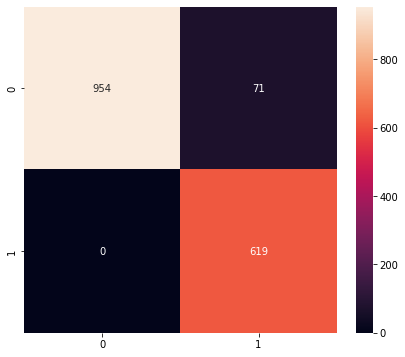

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      1025
           1       0.90      1.00      0.95       619

    accuracy                           0.96      1644
   macro avg       0.95      0.97      0.95      1644
weighted avg       0.96      0.96      0.96      1644



In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [67]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [68]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\HUNGDU~1\AppData\Local\Temp\tmpj9ypur_n\assets


INFO:tensorflow:Assets written to: C:\Users\HUNGDU~1\AppData\Local\Temp\tmpj9ypur_n\assets


6256

# Inference test

In [69]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [70]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [71]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [72]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

Wall time: 0 ns


In [73]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[9.9965656e-01 3.4348559e-04]
0


In [74]:
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler 

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [75]:
pipelines = {
    'lr':make_pipeline(StandardScaler(), LogisticRegression()),
    'rc':make_pipeline(StandardScaler(), RidgeClassifier()),
    'rf':make_pipeline(StandardScaler(), RandomForestClassifier()),
    'gb':make_pipeline(StandardScaler(), GradientBoostingClassifier()),
}

In [76]:
fit_models = {}
for algo, pipeline in pipelines.items():
    model1 = pipeline.fit(X_train, y_train)
    fit_models[algo] = model1

c:\users\hungduong\miniconda3\envs\hand\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [77]:
fit_models

{'lr': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression', LogisticRegression())]),
 'rc': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('ridgeclassifier', RidgeClassifier())]),
 'rf': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier', RandomForestClassifier())]),
 'gb': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('gradientboostingclassifier', GradientBoostingClassifier())])}

In [78]:
fit_models['rc'].predict(X_test)

array([0, 1, 1, ..., 1, 0, 1])

In [79]:
from sklearn.metrics import accuracy_score # Accuracy metrics 
import pickle

In [80]:
for algo, model1 in fit_models.items():
    yhat = model1.predict(X_test)
    print(algo, accuracy_score(y_test, yhat))

lr 0.8126520681265207
rc 0.8138686131386861
rf 1.0
gb 0.9981751824817519


In [81]:
# fit_models['rf'].predict(X_test)[100]
X_test
# model1.predict(X_test)[2]
# model.predict(X_test)

array([[ 0.        ,  0.        ,  0.13015874, ..., -0.35873017,
        -0.7873016 , -0.4063492 ],
       [ 0.        ,  0.        ,  0.17073171, ..., -0.3804878 ,
        -0.20487805, -0.3512195 ],
       [ 0.        ,  0.        ,  0.11111111, ...,  0.19444445,
         0.4814815 ,  0.18518518],
       ...,
       [ 0.        ,  0.        , -0.14358975, ..., -0.25128207,
         0.22564103, -0.20512821],
       [ 0.        ,  0.        , -0.01351351, ...,  0.08783784,
         0.04054054,  0.05405406],
       [ 0.        ,  0.        ,  0.42056075, ..., -0.72897196,
        -0.14018692, -0.7009346 ]], dtype=float32)

In [82]:
y_test

array([0, 1, 0, ..., 1, 0, 0])

In [83]:
with open('model/keypoint_classifier/keypoint_classifiergb.pkl', 'wb') as f:
    pickle.dump(fit_models['gb'], f)